In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload

<IPython.core.display.Javascript object>

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 5. Test Accuracy: 98.63
Variable containing:
 0.6860
 0.4486
 0.0447
 0.2897
[torch.cuda.FloatTensor of size 4 (GPU 0)]



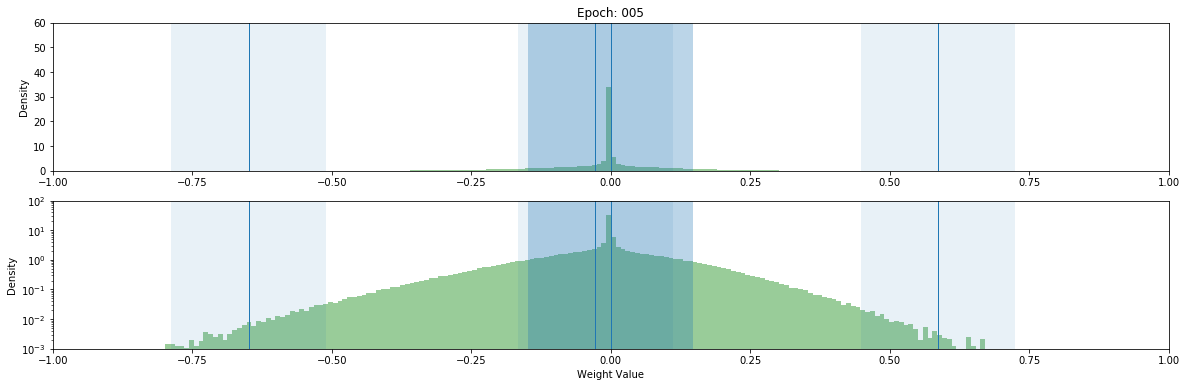

Epoch: 5. Test Accuracy: 98.63
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 10. Test Accuracy: 98.63
Variable containing:
 0.7440
 0.5049
 0.0927
 0.3436
[torch.cuda.FloatTensor of size 4 (GPU 0)]



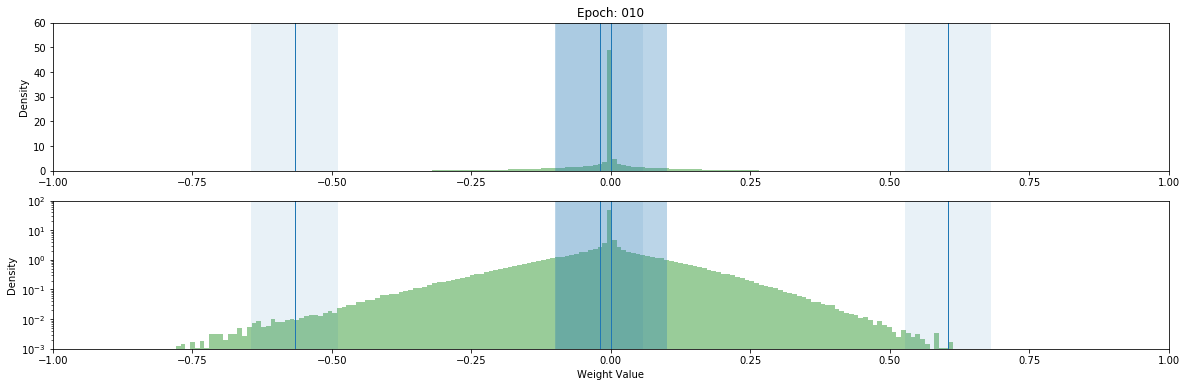

Epoch: 10. Test Accuracy: 98.63
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 15. Test Accuracy: 98.57
Variable containing:
 0.8047
 0.5624
 0.1379
 0.3983
[torch.cuda.FloatTensor of size 4 (GPU 0)]



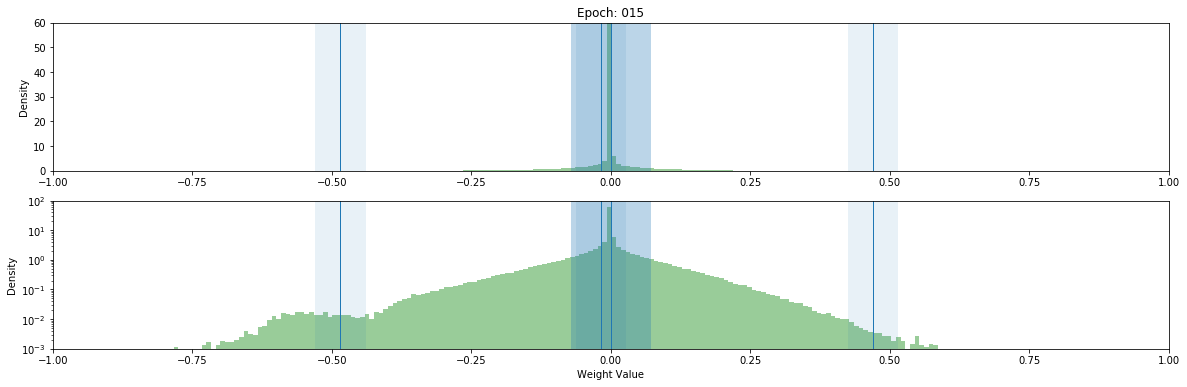

Epoch: 15. Test Accuracy: 98.57
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 20. Test Accuracy: 98.53
Variable containing:
 0.8675
 0.6220
 0.1804
 0.4548
[torch.cuda.FloatTensor of size 4 (GPU 0)]



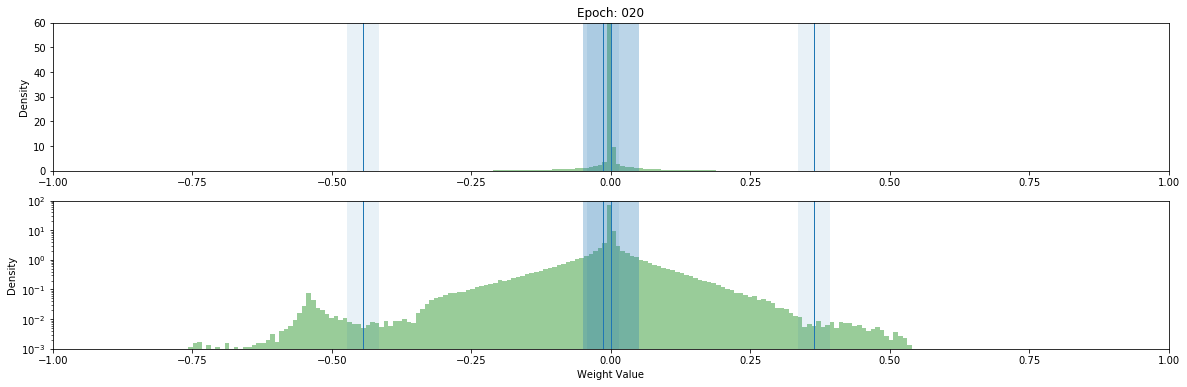

Epoch: 20. Test Accuracy: 98.53
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 25. Test Accuracy: 98.48
Variable containing:
 0.9344
 0.6848
 0.2202
 0.5169
[torch.cuda.FloatTensor of size 4 (GPU 0)]



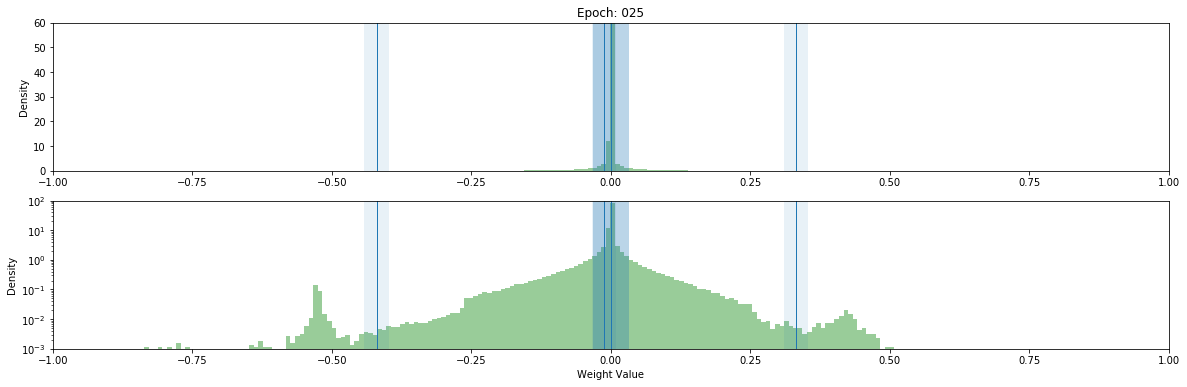

Epoch: 25. Test Accuracy: 98.48
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 30. Test Accuracy: 98.38
Variable containing:
 1.0075
 0.7498
 0.2559
 0.5850
[torch.cuda.FloatTensor of size 4 (GPU 0)]



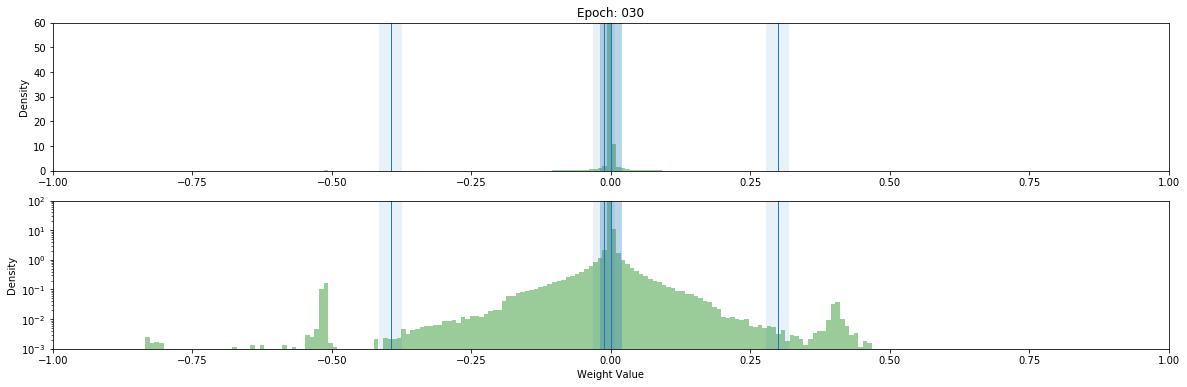

Epoch: 30. Test Accuracy: 98.38
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 35. Test Accuracy: 98.06
Variable containing:
 1.0447
 0.7938
 0.2789
 0.6317
[torch.cuda.FloatTensor of size 4 (GPU 0)]



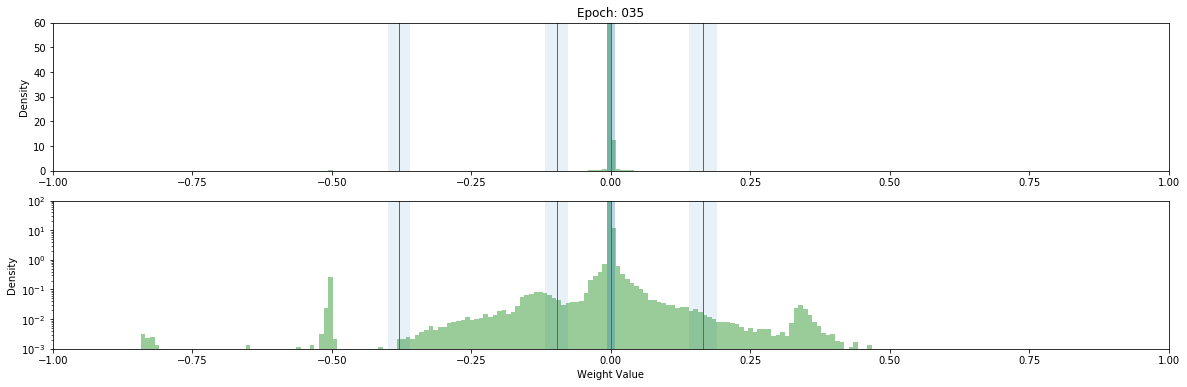

Epoch: 35. Test Accuracy: 98.06
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 40. Test Accuracy: 96.75
Variable containing:
 1.0623
 0.8075
 0.2848
 0.6461
[torch.cuda.FloatTensor of size 4 (GPU 0)]



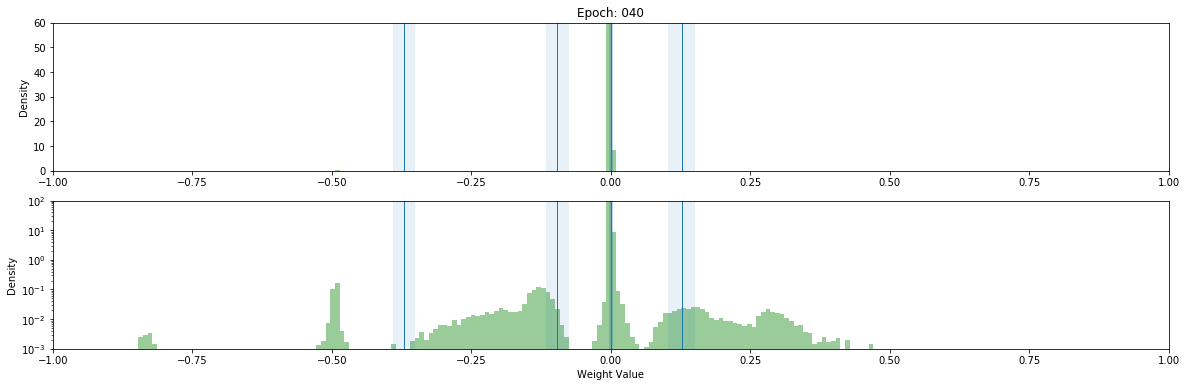

Epoch: 40. Test Accuracy: 96.75
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 45. Test Accuracy: 96.69
Variable containing:
 1.0673
 0.8081
 0.2884
 0.6469
[torch.cuda.FloatTensor of size 4 (GPU 0)]



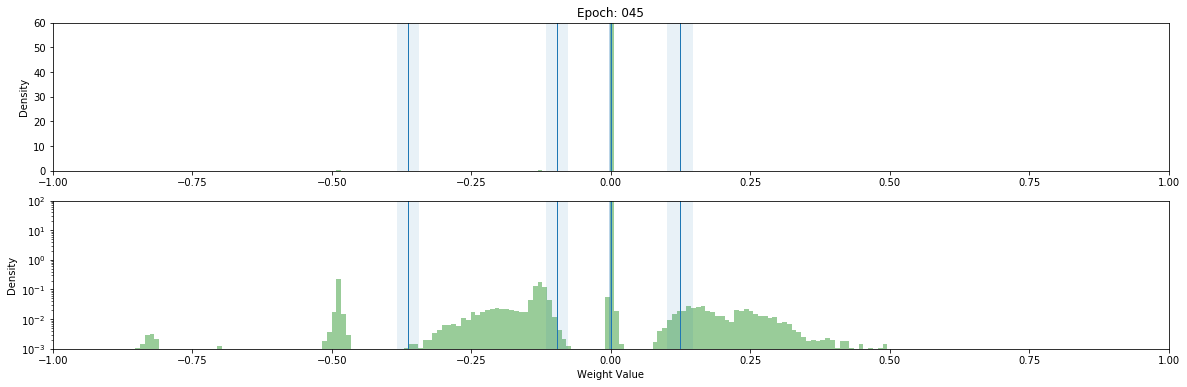

Epoch: 45. Test Accuracy: 96.69
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 50. Test Accuracy: 96.86
Variable containing:
 1.0715
 0.8084
 0.2915
 0.6483
[torch.cuda.FloatTensor of size 4 (GPU 0)]



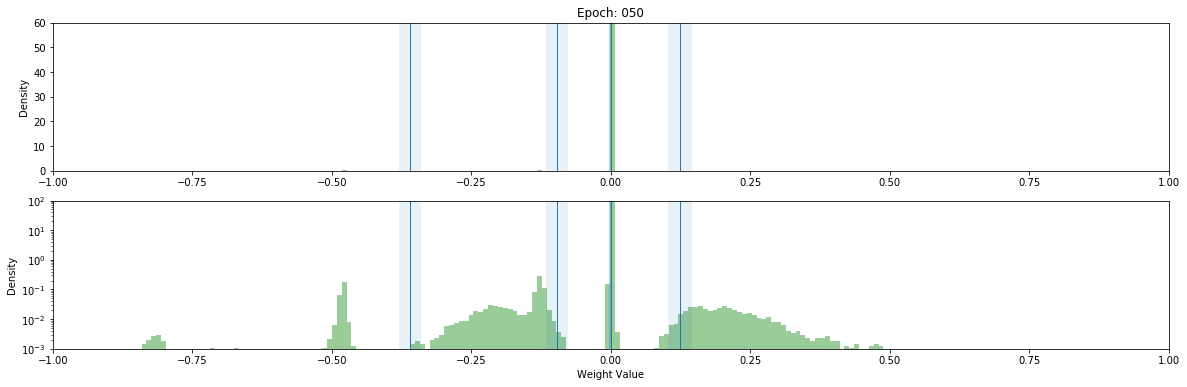

Epoch: 50. Test Accuracy: 96.86
Retrain Test: 96.86, Retrain Validation: 97.02, Prune Test: 74.78, Prune Validation: 75.68, Prune Sparsity: 98.64


In [2]:
#execution example: python retrain.py --model SWSModel --alpha 2500 --beta 10 --tau 1e-6 --mixtures 8 --temp 10
%autoreload 2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import numpy as np

import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, root_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
import copy
import pickle
import argparse
retraining_epochs = 50

###
import matplotlib as plt
%matplotlib inline

def retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, model_save_dir = ""):
    if(data_size == 'search'):
        train_dataset = search_retrain_data
        val_data_full = Variable(search_validation_data(fetch='data')).cuda()
        val_labels_full = Variable(search_validation_data(fetch='labels')).cuda()
        (x_start, x_end) = (40000, 50000)
    if(data_size == 'full'):
        train_dataset = train_data
        (x_start, x_end) = (0, 60000)
    test_data_full = Variable(test_data(fetch='data')).cuda()
    test_labels_full = Variable(test_data(fetch='labels')).cuda()
        
    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model = torch.load(model_load_dir + model_file + '.m').cuda()
        
    if temp == 0:
        criterion = nn.CrossEntropyLoss()
        loader = torch.utils.data.DataLoader(dataset=train_dataset(), batch_size=batch_size, shuffle=True)
    else:
        criterion = nn.MSELoss()
        output = torch.load("{}{}_targets/{}.out.m".format(model_load_dir, model_file.replace("search", "full"), "fc2"))[x_start:x_end]
        output = (nn.Softmax(dim=1)(output/temp)).data
        dataset = torch.utils.data.TensorDataset(train_dataset(fetch='data'), output)
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    exp_name = "m{}_a{}_b{}_r{}_t{}_kdT{}_{}".format(model.name, alpha, beta, retraining_epochs, tau, temp, data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, ab = (alpha, beta), scaling=True)
    gmp.print_batch = False
    
    scaling = True

    optimizable_params = [
        {'params': model.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 1e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}]
    if (scaling):
        optimizable_params = optimizable_params + [{'params': gmp.scale, 'lr': 1e-4}]
        exp_name = exp_name + "_scaling"

    opt = torch.optim.Adam(optimizable_params)

    for epoch in range(retraining_epochs):
        model, loss = retrain_sws_epoch(model, gmp, opt, criterion, loader, tau)
        
        print('Epoch: {}'.format(epoch+1))
        if (trueAfterN(epoch, 5)):
            test_acc = test_accuracy(test_data_full, test_labels_full, model)
            print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
            print(gmp.scale)
            
            ###
            show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
            print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
    
    if(model_save_dir!=""):
        torch.save(model, model_save_dir + '/mnist_retrain_{}.m'.format(exp_name))
        with open(model_save_dir + '/mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
    
    test_accuracy_pre = float((test_accuracy(test_data_full, test_labels_full, model)[0]))
    val_accuracy_pre = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model)[0]))
    
    
    model_prune = copy.deepcopy(model)
    model_prune.load_state_dict(sws_prune(model_prune, gmp))
    prune_acc = (test_accuracy(test_data_full, test_labels_full, model_prune))
    test_accuracy_prune = float((test_accuracy(test_data_full, test_labels_full, model_prune)[0]))
    val_accuracy = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model_prune)[0]))
    sparsity = (special_flatten(model_prune.state_dict())==0).sum()/(special_flatten(model_prune.state_dict())>0).numel() * 100
    print('Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}'
          .format(test_accuracy_pre, val_accuracy_pre, test_accuracy_prune, val_accuracy, sparsity))
    
        
    return val_accuracy, sparsity, model, model_prune, gmp
    
_, _, norm, prune, gmp = retrain_model(25000, 10, 1e-6, 3, 4, 'SWSModel', 'search', "")

In [3]:
gmp.scale.exp()

Variable containing:
 2.9198
 2.2443
 1.3385
 1.9122
[torch.cuda.FloatTensor of size 4 (GPU 0)]

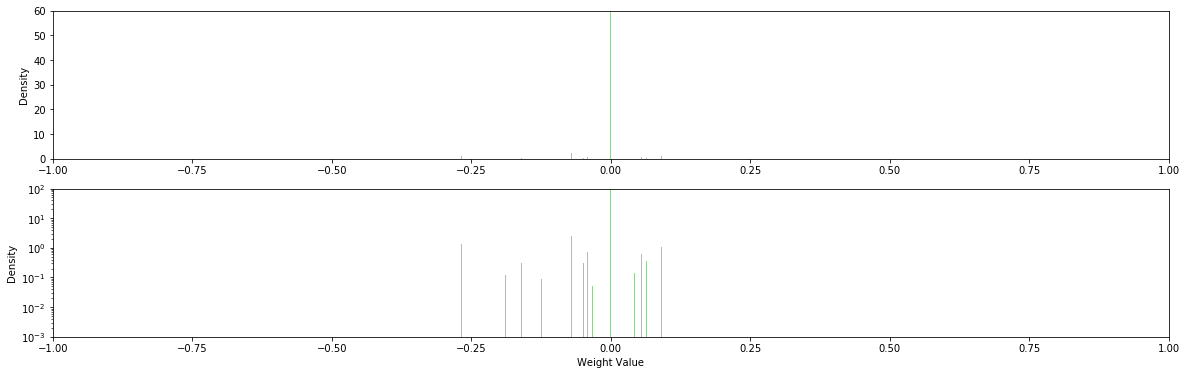

In [4]:
show_sws_weights(prune)

In [195]:
gmp_bkp = copy.deepcopy(gmp.means)
gmp_bkp


-0.3679
-0.1001
 0.1602
[torch.cuda.FloatTensor of size 3 (GPU 0)]

In [199]:
model = copy.deepcopy(prune)

data_size ='search'

if(data_size == 'search'):
    train_dataset = search_train_data()
if(data_size == 'full'):
    train_dataset = train_data()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 0.000)
for epoch in range(10):
    idx_dict = copy.deepcopy(model.state_dict())
    value_dict = copy.deepcopy(model.state_dict())

    #keeping index of mixture, layer by layer
    for l, layer in enumerate(model.state_dict()):
        for m, mean in enumerate(gmp.means):
            idx_dict[layer] [(model.state_dict()[layer] == mean / gmp.scale[int(l/2)].exp().data)] = m + 1 

    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    print('Pruned - Epoch: {}. Test Accuracy: {:.2f}'.format(1, test_acc[0]))
    #show_sws_weights(model)

    ### Mark which tensors belong to which layer in matrices -- mixture_occ

    model, loss = train_epoch(model, optimizer, criterion, train_loader)

    ### Find the new means -- use mixture occ - for scaling use multipliers across all layers 

    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    print('Epoch: {}. Test Accuracy: {:.2f}'.format(1, test_acc[0]))
    #show_sws_weights(model)
    #		-> Calculate new mean for each "cluster"
    new_means = gmp.means.clone()
    for m, mean in enumerate(new_means):
        #print(m, mean)
        cluster_sum = 0
        cluster_elem = 0
        for l, layer in enumerate(model.state_dict()):
            cluster_elem += (idx_dict[layer] == m+1).sum()
            cluster_sum += (model.state_dict()[layer] [idx_dict[layer] == m+1]).sum() * float(gmp.scale[int(l/2)].exp())
            #print (layer, float(mean), float(gmp.scale[int(l/2)].exp()), cluster_sum, cluster_elem)
        new_means[m] = cluster_sum/cluster_elem
    new_means

    #-> Change model parameters according to decision boundaries
    for l, layer in enumerate(model.state_dict()):
        #-> Draw decision boundaries using means
        nml = sorted(list(new_means / gmp.scale[int(l/2)].exp().data) + [0])
        partitions = [(nml[i] + nml[i+1]) * 0.5 for i in range(len(nml)-1)]
        value_dict[layer][model.state_dict()[layer] <= partitions[0]] = float(nml[0])
        for p, partition in enumerate(partitions):
            #print(value_dict[layer][value_dict[layer] < partition].numel())
            #print (layer, partition, float(nml[p]), (model.state_dict()[layer] <= partition).sum())
            value_dict[layer][model.state_dict()[layer] > partition] = float(nml[p+1])

    gmp.means = new_means
    model.load_state_dict(value_dict)
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    print('Repruned - Epoch: {}. Test Accuracy: {:.2f}'.format(1, test_acc[0]))

Pruned - Epoch: 1. Test Accuracy: 74.78
Epoch: 1. Test Accuracy: 93.09


ZeroDivisionError: float division by zero

In [197]:
mean

-0.3678847849369049

In [179]:
prune.state_dict()['fc2.weight'].min()

-0.18793274462223053

In [180]:
value_dict['fc2.weight'].min()

-0.18788480758666992

In [2]:
import sys
sys.path.insert(0,'../src/')

In [1]:
#execution example: python retrain.py --model SWSModel --alpha 2500 --beta 10 --tau 1e-6 --mixtures 8 --temp 10
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune

import copy
import pickle

alpha = 25000
beta = 10
tau = 1e-5
mixtures = 16
model_name = "SWSModel"
temp = 8

#Data
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size

training_epochs = 100
retraining_epochs = 50
model_file = 'mnist_{}_{}'.format(model_name, training_epochs)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()

trim_l = 40000

if temp == 0:
    temp = 0
    criterion = nn.CrossEntropyLoss()
    
    trimmed_data = train_dataset.train_data[trim_l:]
    trimmed_labels = train_dataset.train_labels[trim_l:]
    trimmed_dataset = (trimmed_data, trimmed_labels)
    loader = torch.utils.data.DataLoader(dataset=trimmed_dataset, batch_size=batch_size, shuffle=True)
else:
    temp = float(temp)
    criterion = nn.MSELoss()
    output = torch.load("{}{}/{}.out.m".format(model_dir, model_file, "fc2"))
    output = (nn.Softmax(dim=1)(output/temp)).data
    
    train_data_full = (train_dataset.train_data.float()/255.0).cuda()
    dataset = torch.utils.data.TensorDataset(train_data_full[trim_l:], output[trim_l:])
    
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

ImportError: No module named 'model_archs'

In [56]:
scale = torch.ones(8)

for i,x in enumerate(model.parameters()):
    if (len(x.size())) != 1:
        weight = x.clone().data
    else:
        bias = x.clone().data
        w_var = torch.cat((weight.view(-1), bias)).var()
        scale[i] = w_var
        scale[i-1] = w_var
        
scale/scale.min()
torch.cat((weight.view(-1), bias)).std()

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0
Epoch: 1
Layer Loss: 627.421
Layer Loss: 15.527
Layer Loss: 8048.500
Layer Loss: 24.987
Layer Loss: 364856.500
Layer Loss: 247.245
Layer Loss: 3327.047
Layer Loss: 5.556
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


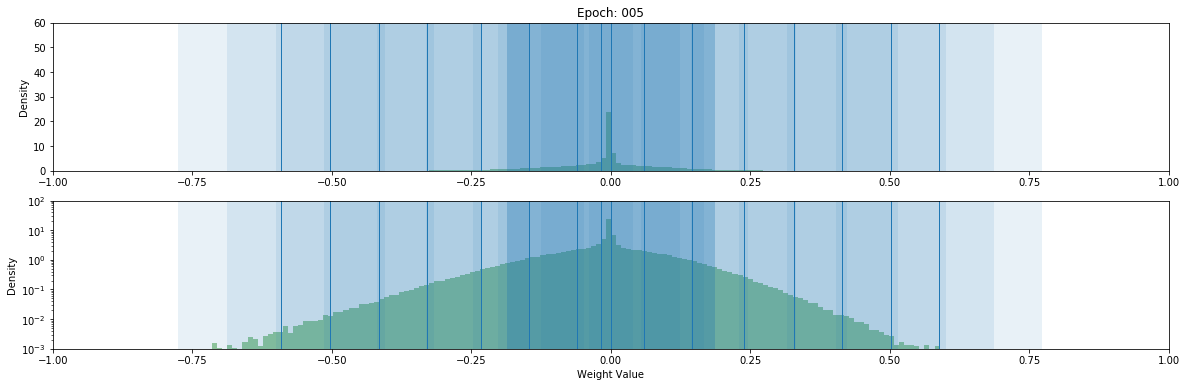

Epoch: 5. Test Accuracy: 98.92
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


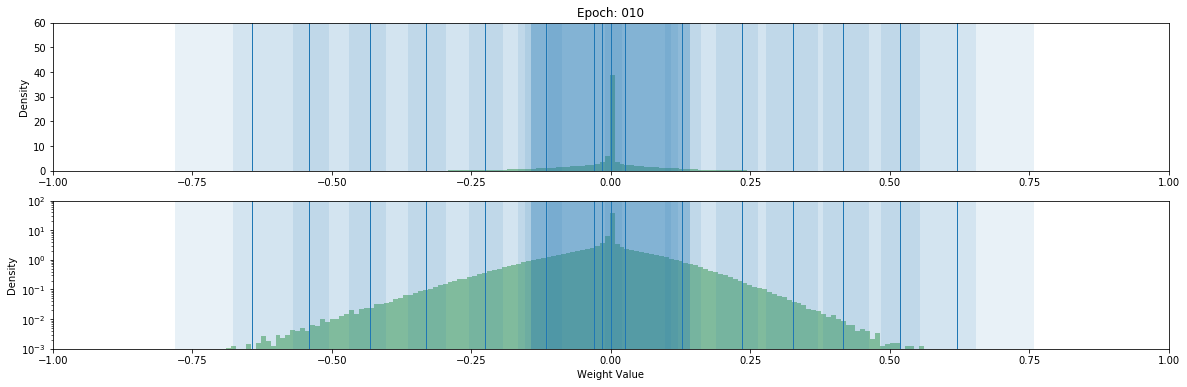

Epoch: 10. Test Accuracy: 98.96
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


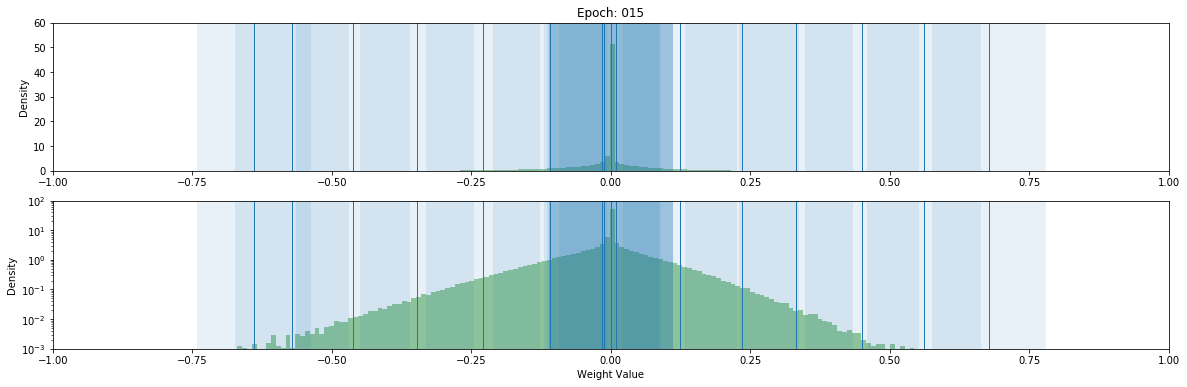

Epoch: 15. Test Accuracy: 98.76
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


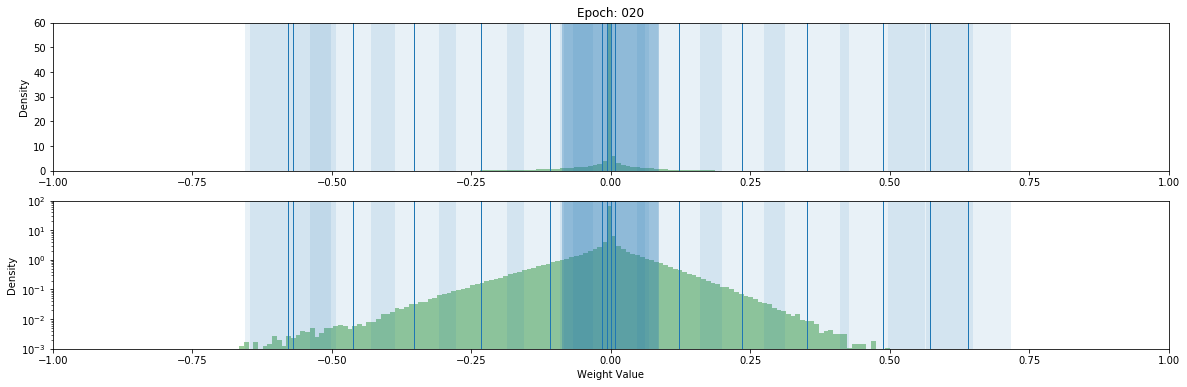

Epoch: 20. Test Accuracy: 98.83
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


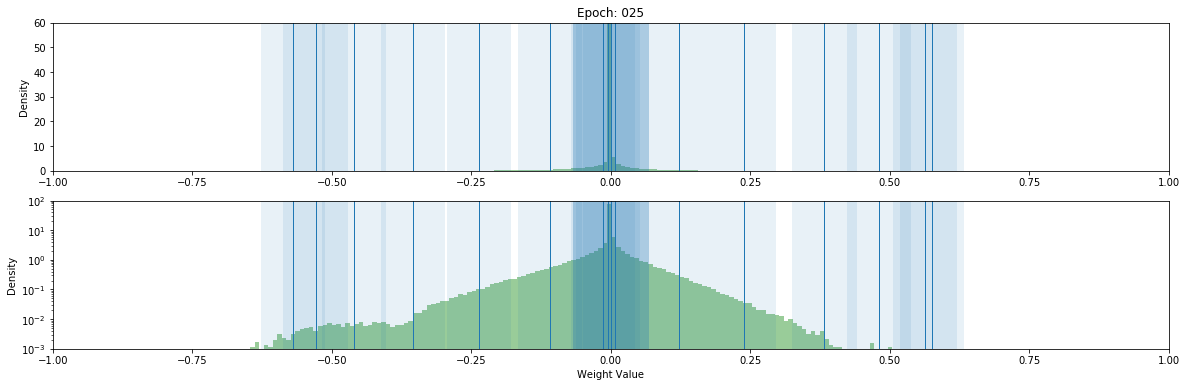

Epoch: 25. Test Accuracy: 98.80
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


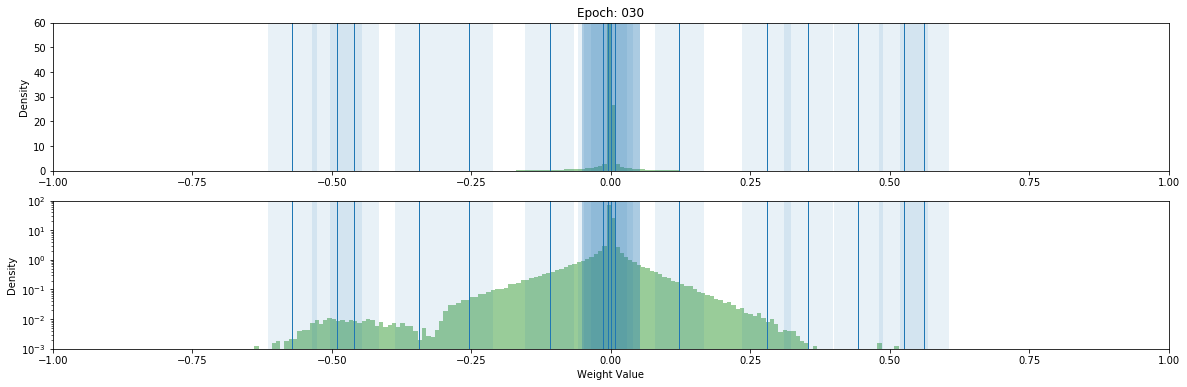

Epoch: 30. Test Accuracy: 98.83
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35


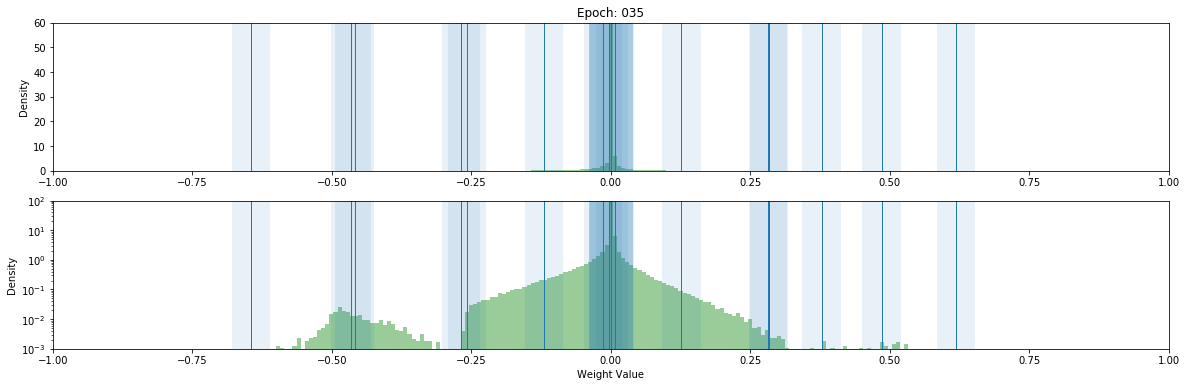

Epoch: 35. Test Accuracy: 98.42
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40


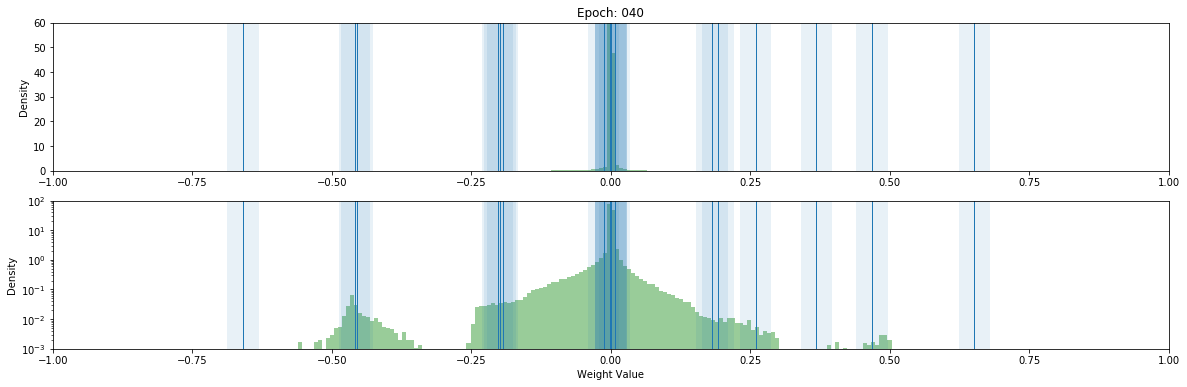

Epoch: 40. Test Accuracy: 97.55
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45


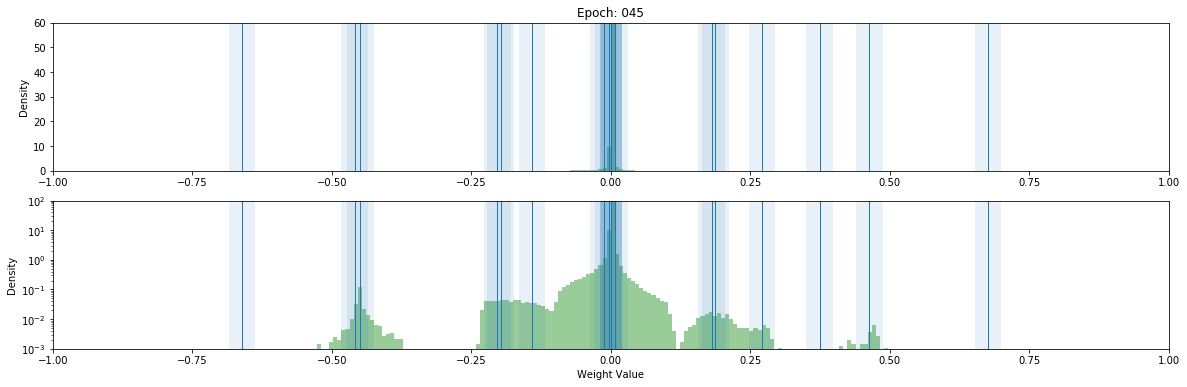

Epoch: 45. Test Accuracy: 95.53
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


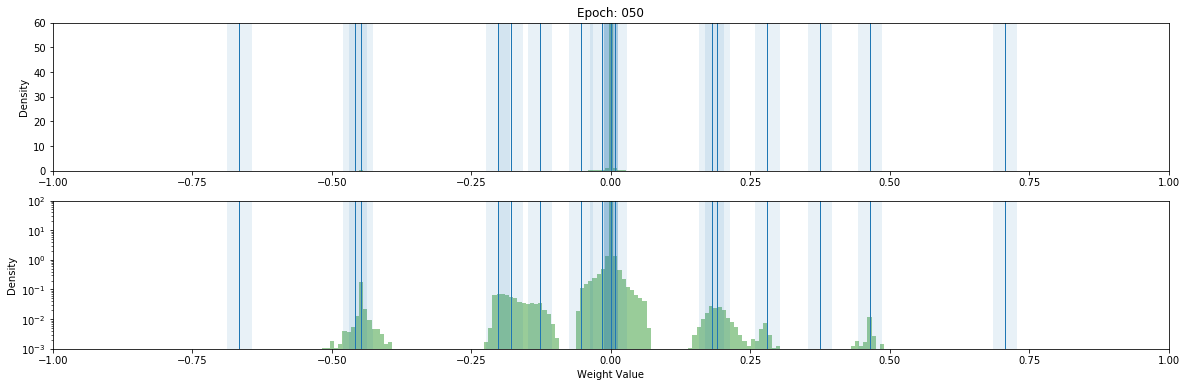

Epoch: 50. Test Accuracy: 91.18


In [2]:
#exp_name = "m{}_a{}_b{}_r{}_t{}_kdT{}".format(model.name, alpha, beta, retraining_epochs, tau, temp)
gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, ab = (alpha, beta), scaling=False)

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)

for epoch in range(retraining_epochs):
    print("Epoch: {}".format(epoch+1))
    model, loss = retrain_sws_epoch(model, gmp, optimizer, optimizer_gmp, optimizer_gmp2, criterion, loader, tau)
    
    if (trueAfterN(epoch, 5)):
        test_acc = test_accuracy(test_data_full, test_labels_full, model)
        show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
        print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

#torch.save(model, model_dir + model_file + '/mnist_model_retrain_{}.m'.format(exp_name))
#with open(model_dir + model_file + '/mnist_model_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
#    pickle.dump(gmp, f)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0
Epoch: 1
Layer Loss: 365.785
Layer Loss: 12.450
Layer Loss: 6596.113
Layer Loss: 24.018
Layer Loss: 364856.500
Layer Loss: 247.245
Layer Loss: 2937.002
Layer Loss: 5.196
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


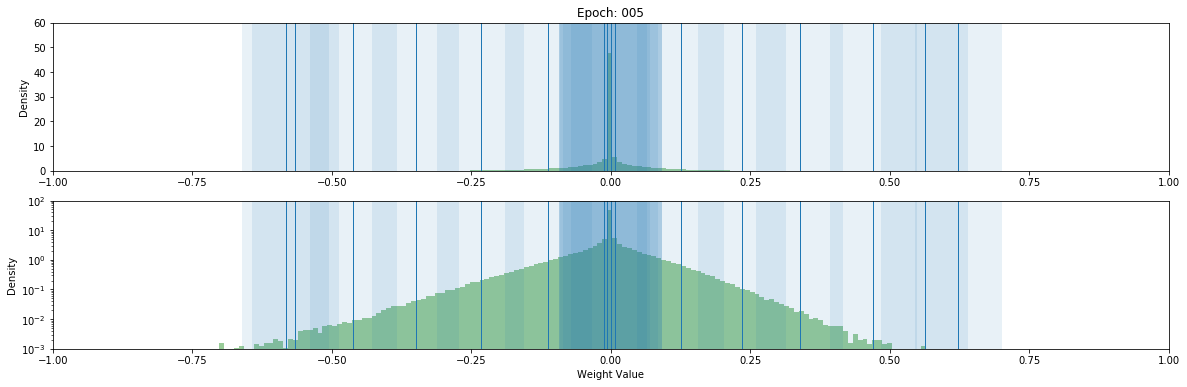

Epoch: 5. Test Accuracy: 98.84
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


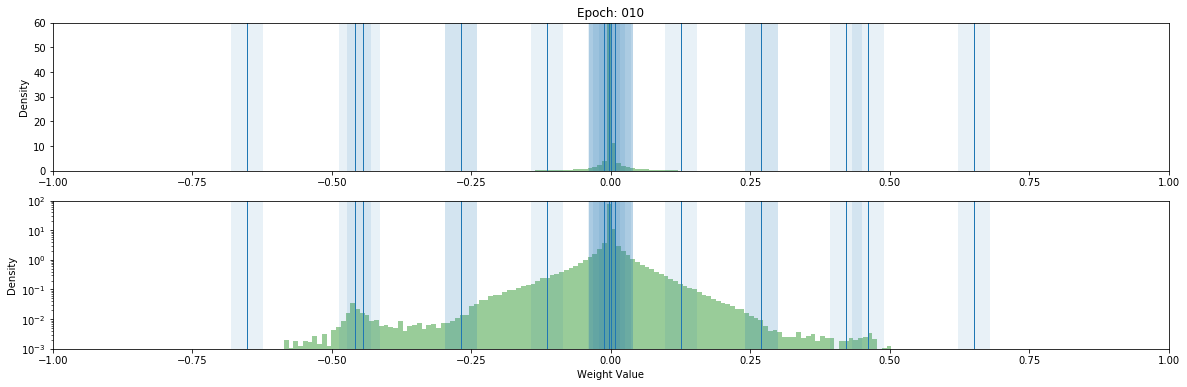

Epoch: 10. Test Accuracy: 98.85
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


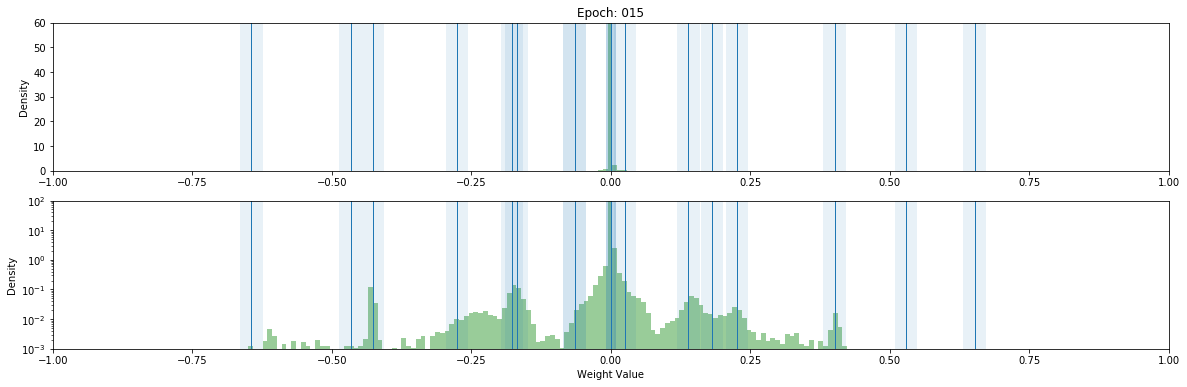

Epoch: 15. Test Accuracy: 97.85
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


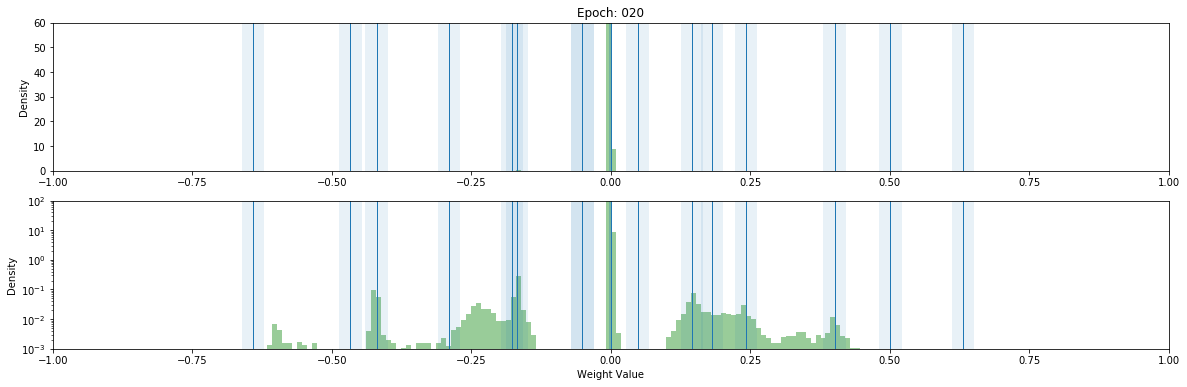

Epoch: 20. Test Accuracy: 96.01
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


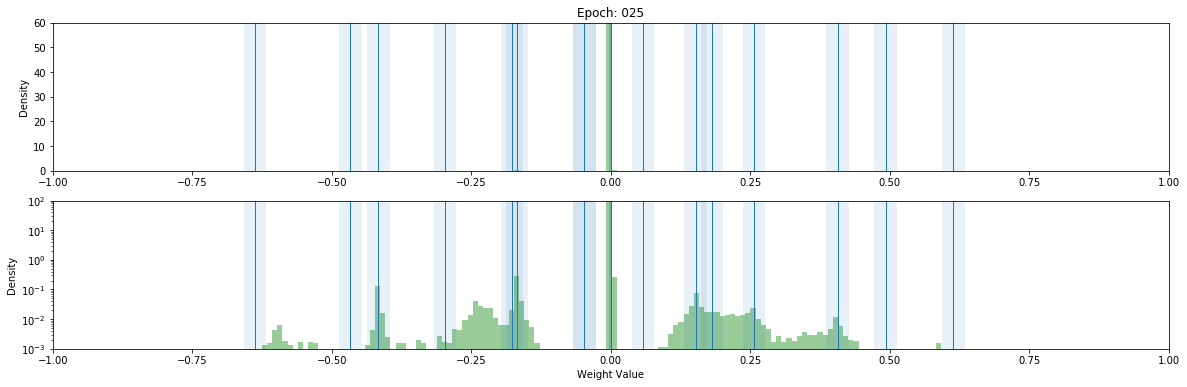

Epoch: 25. Test Accuracy: 96.12
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


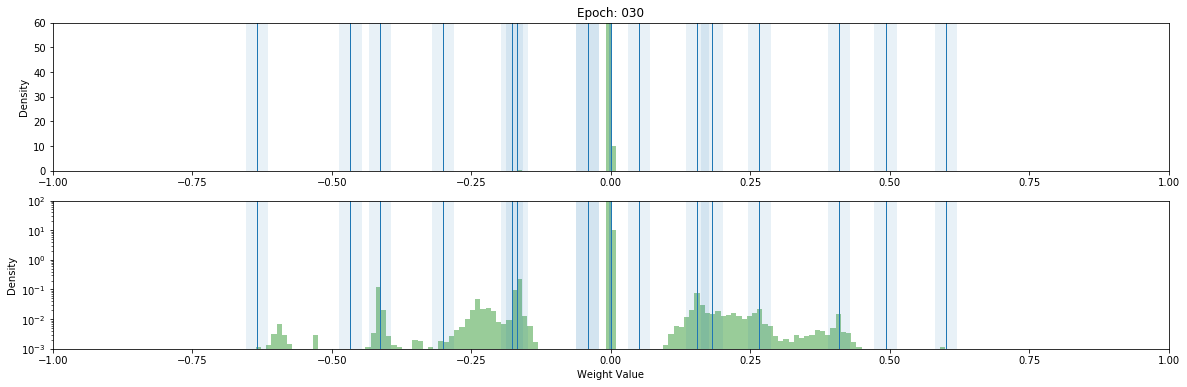

Epoch: 30. Test Accuracy: 96.20
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35


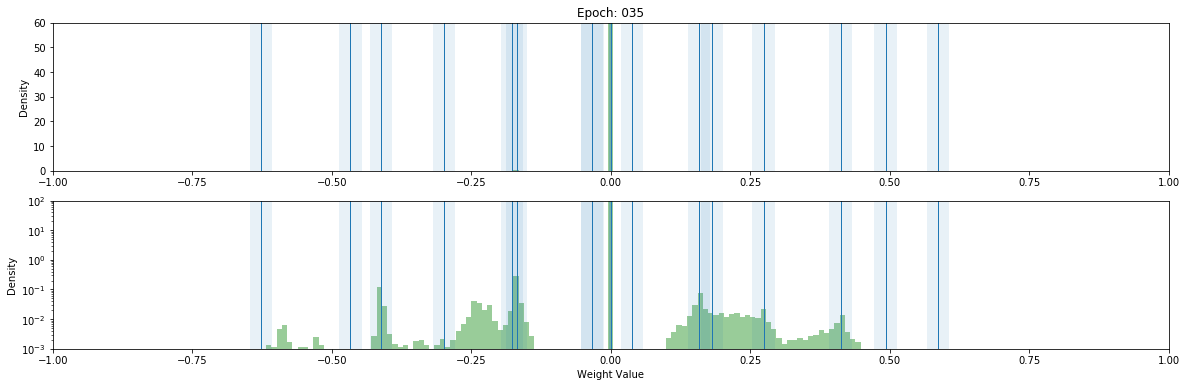

Epoch: 35. Test Accuracy: 96.26
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40


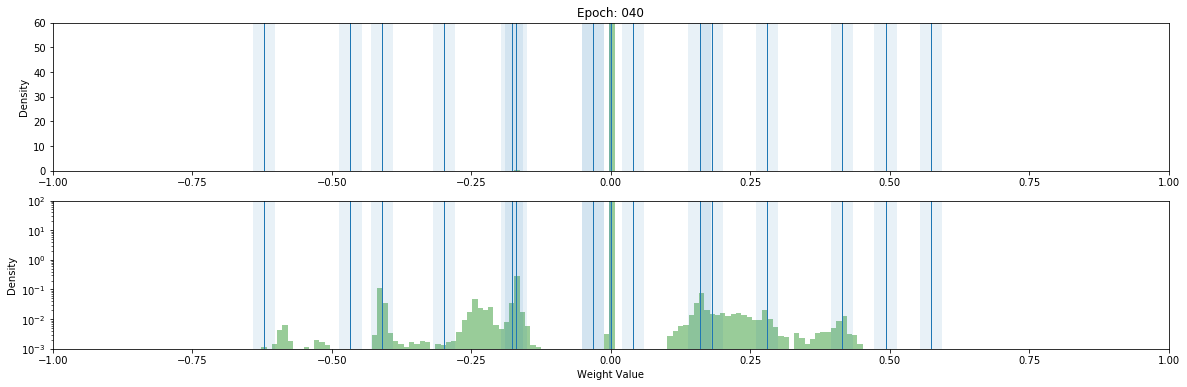

Epoch: 40. Test Accuracy: 96.58
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45


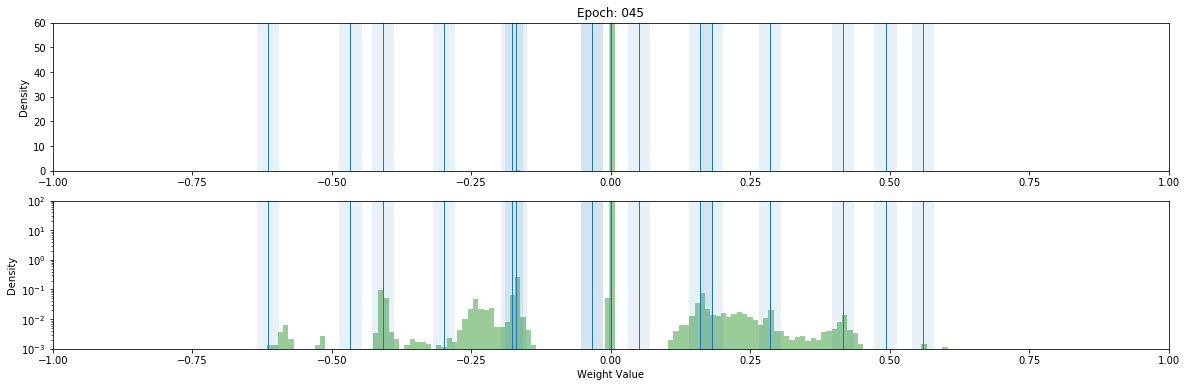

Epoch: 45. Test Accuracy: 96.54
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


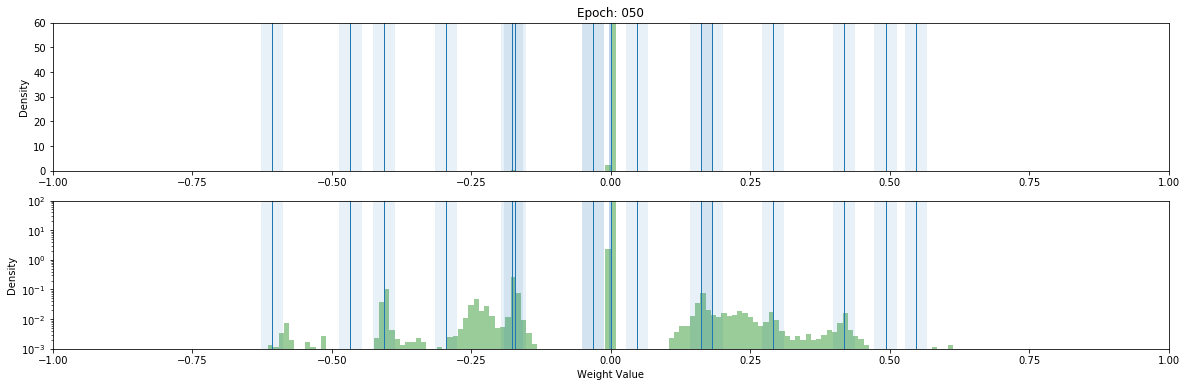

Epoch: 50. Test Accuracy: 96.50


In [9]:
#exp_name = "m{}_a{}_b{}_r{}_t{}_kdT{}".format(model.name, alpha, beta, retraining_epochs, tau, temp)
model_s = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
gmp_s = GaussianMixturePrior(mixtures, [x for x in model_s.parameters()], 0.99, ab = (alpha, beta), scaling = True)

sws_param1_s = [gmp_s.means]
sws_param2_s = [gmp_s.gammas, gmp_s.rhos]

optimizer_s = torch.optim.Adam(model_s.parameters(), lr=1e-4)
optimizer_gmp_s = torch.optim.Adam(sws_param1_s, lr=1e-4)
optimizer_gmp2_s = torch.optim.Adam(sws_param2_s, lr=3e-3)

for epoch in range(retraining_epochs):
    print("Epoch: {}".format(epoch+1))
    model_s, loss = retrain_sws_epoch(model_s, gmp_s, optimizer_s, optimizer_gmp_s, optimizer_gmp2_s, criterion, loader, tau/10)
    
    if (trueAfterN(epoch, 5)):
        test_acc = test_accuracy(test_data_full, test_labels_full, model_s)
        show_sws_weights(model = model_s, means = list(gmp_s.means.data.clone().cpu()), precisions = list(gmp_s.gammas.data.clone().cpu()), epoch = epoch)
        print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

#torch.save(model, model_dir + model_file + '/mnist_model_retrain_{}.m'.format(exp_name))
#with open(model_dir + model_file + '/mnist_model_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
#    pickle.dump(gmp, f)

In [11]:
sws_prune(model_s, gmp_s)

OrderedDict([('conv1.weight', 
              (0 ,0 ,.,.) = 
                0.0000  0.0000  0.0000  0.0000  0.0000
                0.2912  0.0000  0.0000  0.0000  0.2912
                0.0000  0.0000  0.2912  0.0000  0.5464
                0.0000  0.2912  0.0000  0.0000  0.0000
                0.0000  0.0000 -0.4062 -0.6069 -0.4062
              
              (1 ,0 ,.,.) = 
                0.0000  0.0000  0.0000  0.0000  0.0000
                0.0000  0.4182  0.5464  0.0000 -0.4062
                0.0000  0.4182  0.2912  0.0000 -0.4062
                0.0000  0.0000  0.2912  0.0000  0.0000
                0.0000  0.0000  0.0000  0.2912  0.2912
              
              (2 ,0 ,.,.) = 
                0.0000  0.0000 -0.2955 -0.0315 -0.2955
                0.0000  0.0000  0.0000  0.0000 -0.2955
               -0.4062  0.0000  0.5464  0.5464  0.0000
                0.0000  0.5464  0.0000  0.0000  0.0000
                0.0000  0.0000  0.4182  0.4182  0.0000
              
            